# Identifying objects in images.
## 1st dataset to try: CIFAR 10

Starting lines and imports

In [16]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

from torchsummary import summary

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load CIFAR 10

#### Define transforms for the dataset and load

In [4]:
transform_tr = transforms.Compose([transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(), transforms.ToTensor(),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))])
transform_tst = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.4942, 0.4851, 0.4504),(0.2467, 0.2429, 0.2616))])

In [3]:
# CIFAR-10 training dataset and data loader
train_batch_size = 32
val_batch_size = 5000

indices = np.arange(50000)
np.random.shuffle(indices)

tr_sampler = torch.utils.data.SubsetRandomSampler(indices[:45000])
val_sampler = torch.utils.data.SubsetRandomSampler(indices[45000:50000])

train_dataset = datasets.CIFAR10('CIFAR10',
                                 train=True, 
                                 download=True, 
                                 transform=transform_tr)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=False,
                                          sampler=tr_sampler,
                                          num_workers=2)
val_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=val_batch_size,
                                          shuffle=False,
                                          sampler=val_sampler)

Files already downloaded and verified


In [6]:
# CIFAR-10 test dataset and data loader
test_batch_size = 10000

test_dataset = datasets.CIFAR10('CIFAR10', 
                                train=False, 
                                download=True, 
                                transform=transform_tst)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=True,
                                         num_workers=2)

Files already downloaded and verified


In [7]:
# num of batches in each training epoch
len(train_loader)

1407

In [33]:
for j, (images, labels) in enumerate(train_loader):
    if j == 1:
        print(images.shape)

torch.Size([32, 3, 32, 32])


In [8]:
def mean_and_stddev(loader):
    chsum = 0
    for j, (images, labels) in enumerate(loader):
        chsum += images.sum(dim=(0,2,3), keepdim=True)
    mean = chsum/len(loader.dataset.data)/images.size(2)/images.size(3)
    print(mean.view(-1))
    chsum = 0
    for j, (images, labels) in enumerate(loader):
        chsum += (images - mean).pow(2).sum(dim=(0,2,3), keepdim=True)
    std = torch.sqrt(chsum/(len(loader.dataset.data)*images.size(2)*images.size(3)-1))
    print(std.view(-1))

In [7]:
mean_and_stddev(train_loader)

tensor([0.0011, 0.0005, 0.0007])
tensor([0.9493, 0.9491, 0.9493])


In [8]:
mean_and_stddev(test_loader)

tensor([5.7950e-05, 1.2928e-04, 3.4801e-05])
tensor([0.9998, 1.0000, 1.0000])


#### Function to show individual image and associated label

In [9]:
def show_image(image_num):
    plt.imshow(train_loader.dataset.data[image_num,:,:])
    target = train_loader.dataset.targets[image_num]
    print("This image is a(n) " + str(train_loader.dataset.classes[target])+".")

This image is a(n) airplane.


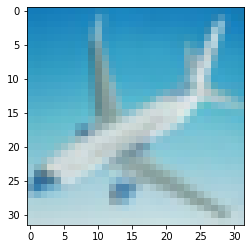

In [10]:
show_image(1701)

This image is a(n) ship.


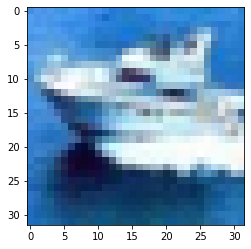

In [11]:
show_image(9154)

# Initialize settings for Neural Network

In [143]:
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        # Convolutional Layer - 
        self.conv1 = nn.Conv2d(3,6,5, padding=1)
        
        # 2nd Convolutional Layer -
        self.conv2 = nn.Conv2d(6,16,5, padding=1)
        
        # 3rd Convolutional Layer -
        self.conv3 = nn.Conv2d(16,32,5, padding=1)
        
        # Max Pooling layers - 
        self.pool = nn.MaxPool2d(2,2)
             
        # 3 fully connected layers
        self.fc1 = nn.Linear(4608, 250)
        self.fc2 = nn.Linear(250, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)
        
        #Dropout for regularization using default p=0.5
        #self.dr1 = nn.Dropout2d()
        self.dr2 = nn.Dropout()
        
        # Activation function
        self.activ1 = nn.ReLU()
        #self.activ1 = nn.Tanh()
        #self.activ2 = nn.LocalResponseNorm(2)
        
    def forward(self, x):
        # 2 convolutional / pooling layers
        x = self.activ1(self.conv1(x))
        x = self.activ1(self.conv2(x))
        x = self.pool(x)
        x = self.activ1(self.conv3(x))
        
        # 2 fully connected hidden layers
        x = x.view(x.shape[0],-1)
        x = self.activ1(self.fc1(x))
        x = self.dr2(x)
        x = self.activ1(self.fc2(x))
        x = self.dr2(x)
        x = self.activ1(self.fc3(x))
        x = self.dr2(x)
        
        # final output layer
        x = self.fc4(x)
        
        return x

In [153]:
class Neural_Network2(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()
        # Convolutional Layer - 
        self.conv1 = nn.Conv2d(3,100,3, padding=1)
        
        # 2nd Convolutional Layer -
        self.conv2 = nn.Conv2d(100,200,2, padding=1)
        
        # 3rd Convolutional Layer -
        self.conv3 = nn.Conv2d(200,300,2, padding=1)
        self.conv4 = nn.Conv2d(300,400,2, padding=1)
        self.conv5 = nn.Conv2d(400,500,2, padding=1)
        
        # Max Pooling layers - 
        self.pool = nn.MaxPool2d(2,2)
             
        # 3 fully connected layers
        #self.fc1 = nn.Linear(4608, 250)
        #self.fc2 = nn.Linear(250, 120)
        #self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(4500, 10)
        
        #Dropout for regularization using default p=0.5
        #self.dr1 = nn.Dropout2d()
        self.dr2 = nn.Dropout()
        
        # Activation function
        self.activ1 = nn.ReLU()
        #self.activ1 = nn.Tanh()
        #self.activ2 = nn.LocalResponseNorm(2)
        
    def forward(self, x):
        # 2 convolutional / pooling layers
        x = self.activ1(self.conv1(x))
        x = self.pool(x)
        x = self.activ1(self.conv2(x))
        x = self.pool(x)
        x = self.activ1(self.conv3(x))
        x = self.pool(x)
        x = self.activ1(self.conv4(x))
        x = self.pool(x)
        x = self.activ1(self.conv5(x))
        
        
        # 2 fully connected hidden layers
        x = x.view(x.shape[0],-1)
        #x = self.activ1(self.fc1(x))
        #x = self.dr2(x)
        #x = self.activ1(self.fc2(x))
        #x = self.dr2(x)
        #x = self.activ1(self.fc3(x))
        #x = self.dr2(x)
        
        # final output layer
        x = self.fc4(x)
        
        return x

class Neural_Network2(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()
        # Convolutional Layer - 
        self.conv1 = nn.Conv2d(3,6,3)
        
        # 2nd Convolutional Layer -
        self.conv2 = nn.Conv2d(6,6,5)
        
        # 3rd Convolutional Layer -
        self.conv3 = nn.Conv2d(6,8,5)
        
        # 4th Convolutional Layer
        self.conv4 = nn.Conv2d(8,10,5)
        
        # Max Pooling layers - 
        self.pool = nn.MaxPool2d(2,2)
             
        # 3 fully connected layers
        self.fc1 = nn.Linear(40, 10)
        
        # Activation function
        self.activ1 = nn.ReLU()
        
    def forward(self, x):
        # 2 convolutional / pooling layers
        x = self.activ1(self.conv1(x))
        x = self.activ1(self.conv2(x))
        x = self.pool(x)
        x = self.activ1(self.conv3(x))
        x = self.activ1(self.conv4(x))
        x = self.pool(x)
        
        # 2 fully connected hidden layers
        x = x.view(-1,40)
        x = self.activ1(self.fc1(x))
        
        return x

#All fully connected layer architecture
class Neural_Network_Linear(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(32* 32 * 3, 256)
        self.fc2 = nn.Linear(256,200)
        self.fc3 = nn.Linear(200, 10)
        self.activ = nn.functional.relu
        
    def forward(self, x):
        x = self.activ(self.fc1(x))
        x = self.activ(self.fc2(x))
        x = self.fc3(x)
        
        return x

#VGG16 architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv_layer = nn.Sequential(
        
            #1st conv layer block
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #2nd conv layer block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            #3rd conv layer block
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
            #fully connected layers block
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512,10)
        )
        
            #perform forward
        def forward(self, x):
            #conv layers
            x = self.conv_layer(x)
            #flatten
            x = x.view(x.size(0), -1)
            #fully connected layer
            x = self.fc_layer(x)
            
            return x

## Function to calculate classification prediction accuracy

In [84]:
def cpu_or_gpu():
    train_on_gpu = torch.cuda.is_available()
    if not train_on_gpu:
        #print("CUDA is not available. Using CPU.")
        device = torch.device('cpu')
    else:
        #print("CUDA is available. Using GPU.")
        device = torch.device('cuda:0')
    return device

In [154]:
neural_network = Neural_Network2()
device = cpu_or_gpu()
neural_network.to(device)

Neural_Network2(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(100, 200, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(200, 300, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(300, 400, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(400, 500, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc4): Linear(in_features=4500, out_features=10, bias=True)
  (dr2): Dropout(p=0.5, inplace=False)
  (activ1): ReLU()
)

In [155]:
summary(neural_network, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 32, 32]           2,800
              ReLU-2          [-1, 100, 32, 32]               0
         MaxPool2d-3          [-1, 100, 16, 16]               0
            Conv2d-4          [-1, 200, 17, 17]          80,200
              ReLU-5          [-1, 200, 17, 17]               0
         MaxPool2d-6            [-1, 200, 8, 8]               0
            Conv2d-7            [-1, 300, 9, 9]         240,300
              ReLU-8            [-1, 300, 9, 9]               0
         MaxPool2d-9            [-1, 300, 4, 4]               0
           Conv2d-10            [-1, 400, 5, 5]         480,400
             ReLU-11            [-1, 400, 5, 5]               0
        MaxPool2d-12            [-1, 400, 2, 2]               0
           Conv2d-13            [-1, 500, 3, 3]         800,500
             ReLU-14            [-1, 50

In [156]:
def accuracy(outputs, labels):
    prediction = outputs.cpu().max(1, keepdim=True)[1].squeeze()
    prediction_comp = torch.eq(prediction.cpu(), labels.cpu())
    prediction_comp = prediction_comp.sum().numpy() / torch.numel(prediction.cpu())
    return prediction_comp * 100

In [157]:
neural_network.train()
criterion = nn.CrossEntropyLoss()

# Initial hyperparameters
number_of_epochs = 100
step_size = 0.01
momentum_parameter = 0.9
weight_decay = 0.001

# Initialize optimiser
optimiser = optim.SGD(neural_network.parameters(), lr=step_size, momentum=momentum_parameter, weight_decay=weight_decay)


# initialize lists for running counts of loss and accuracy
running_loss = []
running_val_loss = []
running_training_accuracy = []
running_training_accuracy.append(0)
running_val_accuracy = []
running_val_accuracy.append(0)

print("Log -- Step size: {}, Momentum: {}, batch_size = {}".format(step_size,momentum_parameter,train_batch_size))
# loop for epochs
for k in range(number_of_epochs):
    device = cpu_or_gpu()
    neural_network.to(device)
    
    # initialize epoch loss and training accuracy
    epoch_loss = 0
    training_accuracy = 0
    
    
    # handle reducing step size at 15th iteration and 50th iteration.
    if k > 49:
        step_size = 0.0001
        optimiser = optim.SGD(neural_network.parameters(), lr=step_size, momentum=momentum_parameter, weight_decay=weight_decay)
        if k == 50: 
            print("Log -- Step size: {}, Momentum: {}, batch_size = {}".format(step_size,momentum_parameter,train_batch_size))
            
    elif k > 9:
        step_size = 0.001
        optimiser = optim.SGD(neural_network.parameters(), lr=step_size, momentum=momentum_parameter, weight_decay=weight_decay)
        if k == 10: 
            print("Log -- Step size: {}, Momentum: {}, batch_size = {}".format(step_size,momentum_parameter,train_batch_size))
     
    # Main Training Loop
    for j, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimiser.zero_grad()
        outputs = neural_network(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        
        epoch_loss += loss.item()
        training_accuracy += accuracy(outputs, labels)
    
    # Caclulate average loss and accuracy for each epoch
    running_loss.append(epoch_loss/len(train_loader))
    running_training_accuracy.append(training_accuracy/len(train_loader))
    
    # Validation test once per epoch
    device = torch.device('cpu')
    neural_network.to(device)
    val_images, val_labels = iter(val_loader).next()
    val_images, val_labels = val_images.to(device), val_labels.to(device)
    val_outputs = neural_network(val_images)
    val_loss = criterion(val_outputs, val_labels).item()
    
    # Store validation loss and accuracy
    running_val_loss.append(val_loss)
    val_accuracy = accuracy(val_outputs, val_labels)
    running_val_accuracy.append(val_accuracy)
    
    if k % 1 == 0:
        print("Epoch {a}/{b} -> Tr. Loss = {c:.2f}, Val. Loss = {d:.2f}, Tr. Acc = {e:.2f}, Val. Acc = {f:.2f}".format(a=k, b=number_of_epochs, c=running_loss[-1], d=running_val_loss[-1], e=running_training_accuracy[-1], f=running_val_accuracy[-1]))
    
    #if (len(running_val_loss) > 3) and (running_val_loss[-3] - running_val_loss[-1] < 0):
        #break
        
print("Final Epoch {} -> Loss = {}".format(k, running_loss[-1]))

Log -- Step size: 0.01, Momentum: 0.9, batch_size = 32
Epoch 0/100 -> Tr. Loss = 1.75, Val. Loss = 1.43, Tr. Acc = 34.48, Val. Acc = 46.84
Epoch 1/100 -> Tr. Loss = 1.26, Val. Loss = 1.14, Tr. Acc = 54.60, Val. Acc = 59.12
Epoch 2/100 -> Tr. Loss = 1.02, Val. Loss = 0.97, Tr. Acc = 63.78, Val. Acc = 66.00
Epoch 3/100 -> Tr. Loss = 0.89, Val. Loss = 0.91, Tr. Acc = 68.83, Val. Acc = 68.14
Epoch 4/100 -> Tr. Loss = 0.81, Val. Loss = 0.78, Tr. Acc = 71.77, Val. Acc = 71.86
Epoch 5/100 -> Tr. Loss = 0.75, Val. Loss = 0.76, Tr. Acc = 73.59, Val. Acc = 73.58
Epoch 6/100 -> Tr. Loss = 0.72, Val. Loss = 0.78, Tr. Acc = 75.04, Val. Acc = 72.76
Epoch 7/100 -> Tr. Loss = 0.68, Val. Loss = 0.67, Tr. Acc = 76.04, Val. Acc = 76.08
Epoch 8/100 -> Tr. Loss = 0.65, Val. Loss = 0.66, Tr. Acc = 77.38, Val. Acc = 77.28
Epoch 9/100 -> Tr. Loss = 0.62, Val. Loss = 0.65, Tr. Acc = 78.27, Val. Acc = 77.28
Log -- Step size: 0.001, Momentum: 0.9, batch_size = 32
Epoch 10/100 -> Tr. Loss = 0.47, Val. Loss = 0.53

KeyboardInterrupt: 

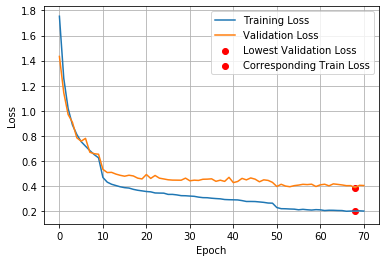

In [158]:
plt.plot(running_loss, label="Training Loss")
plt.plot(running_val_loss, label="Validation Loss")
for i in range(len(running_val_loss)):
    if running_val_loss[i] == np.min(running_val_loss):
        lowest_index = i
plt.scatter(lowest_index, running_val_loss[lowest_index], label="Lowest Validation Loss", c="r")
plt.scatter(lowest_index, running_loss[lowest_index], label="Corresponding Train Loss", c="r")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid()
plt.show()

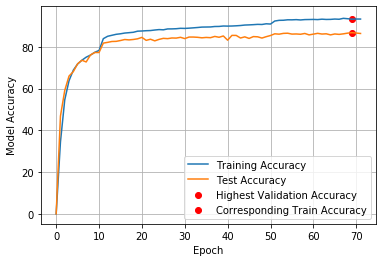

In [159]:
plt.plot(running_training_accuracy, label="Training Accuracy")
plt.plot(running_val_accuracy, label="Test Accuracy")
for i in range(len(running_val_accuracy)):
    if running_val_accuracy[i] == np.max(running_val_accuracy):
        highest_index = i
plt.scatter(highest_index, running_val_accuracy[highest_index], label="Highest Validation Accuracy", c="r")
plt.scatter(highest_index, running_training_accuracy[highest_index], label="Corresponding Train Accuracy", c="r")
plt.legend()
plt.ylabel("Model Accuracy")
plt.xlabel("Epoch")
plt.grid()
plt.show()

In [174]:
## Accuracy on full test dataset (10,000 test images)
def test_on_testing_data():
    indices = np.arange(5000)
    np.random.shuffle(indices)
    
    test_batch_size = 10000

    test_dataset = datasets.CIFAR10('CIFAR10', 
                                train=False, 
                                download=True, 
                                transform=transform_tst)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=False,
                                        sample=torch.utils.data.SubsetRandomSampler(indices[:5000]))
    
    
    device = torch.device('cpu')
    neural_network.to(device)
    neural_network.eval()
    test_accuracy = 0
    epoch_loss = 0
    for j, (test_images, test_labels) in enumerate(test_loader1):
        test_outputs = neural_network(test_images)
        epoch_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += accuracy(test_outputs, test_labels)
    test_accuracy = test_accuracy/len(test_loader1)
    test_loss = epoch_loss/len(test_loader1)
    test_accuracy = accuracy(test_outputs, test_labels)
    print("Test Loss is : {a:.2f}".format(a=test_loss))
    print("Test Accuracy is : {a:.2f}%".format(a=test_accuracy))

In [175]:
test_on_testing_data()

Files already downloaded and verified


MemoryError: 

In [176]:
## Accuracy on full train dataset (50,000 training images) without data augmentation
def test_on_training_data():
    transform_tr1 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))])
    train_dataset1 = datasets.CIFAR10('CIFAR10',
                                 train=True, 
                                 download=True, 
                                 transform=transform_tr1)

    train_loader1 = torch.utils.data.DataLoader(train_dataset1,
                                          batch_size=10000,
                                          shuffle=True)
    device = torch.device('cpu')
    neural_network.to(device)
    neural_network.eval()
    test_accuracy = 0
    epoch_loss += loss.item()
    for j, (test_images, test_labels) in enumerate(train_loader1):
        test_outputs = neural_network(test_images)
        epoch_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += accuracy(test_outputs, test_labels)
    test_accuracy = test_accuracy/len(train_loader1)
    test_loss = epoch_loss/len(train_loader1)
    print("Training Loss (Full Dataset) is : {a:.2f}".format(a=test_loss))
    print("Training Accuracy (Full Dataset) is : {a:.2f}%".format(a=test_accuracy))

In [177]:
test_on_training_data()

Files already downloaded and verified


MemoryError: 

In [178]:
def test_single_prediction():
    device = torch.device('cpu')
    neural_network.to(device)
    neural_network.eval()
    indices = np.arange(10000)
    np.random.shuffle(indices)
    sampler = torch.utils.data.SubsetRandomSampler(indices[:1])
    

    transform_tr1 = transforms.Compose([transforms.ToTensor()])
    test_dataset1 = datasets.CIFAR10('CIFAR10',

                                 train=False, 

                                 download=True, 

                                 transform=transform_tr1)
    test_loader1 = torch.utils.data.DataLoader(test_dataset1, batch_size=1, shuffle=False, sampler=sampler)
    for test_images, test_labels in test_loader1:
        sample_image = test_images[0,:,:]    # Reshape them according to your needs.
        sample_label = test_labels[0]     
    sample_image = test_images[0,:,:]    # Reshape them according to your needs.
    sample_label = test_labels[0]
    output = neural_network(test_images)
    _, predicted = torch.max(output, 1)
    print("Predicted label is: {} - {}".format(predicted[0], train_dataset.classes[predicted[0]]))
    print("Actual label is: {} - {}".format(sample_label, train_dataset.classes[sample_label]))
    plt.imshow(np.transpose(sample_image, (1,2,0)))

In [179]:
test_single_prediction()

Files already downloaded and verified


MemoryError: 

In [181]:
## For saving neural network parameters
model = neural_network
torch.save(model.state_dict(), "Conv-NN-ReLU-100-200-300-400-500")

In [20]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

NameError: name 'TheModelClass' is not defined